# Time Aware Recommendations: When to Deliver A Message to Optimize Likelihood of an Action

## Overview

In Next Best Action (NBA) recommender, we want to predict the timing of the next best email to send to a customer at a point in time. This notebook is going to utilize a fake dataset to help demonstrate a potential approach for NBA. Here we give a brief introduction to some of the elements of our problem space.

The likelihood of a customer to take an action after receiving a message is a combined effect of desire to take the action and timing of the message. An action we are offering in the message must both be intrinsically desired by a customer and the time must be right for the customer to take the action. Put another way, the customer has to want to take the action and the message to containing the action opportunity must be delivered to them at the right time. 

No negative feedback is available for our system. Action data, in contrast to rating data, is implicit with non-actions that are not necessarily indicating dislike. The unlabeled data is a mixture of positive and negative
samples, a problem usually referred to as _positive-unlabeled (PU) learning_.

Temporal recommendation focuses on modeling absolute timestamps to capture the temporal dynamics of users and items. For example, the popularity of an item might change during different time slots, or users’ average ratings might increase or decrease over time. These models are useful when exploring the temporal changes in datasets. Instead of sequential patterns, they consider temporal patterns which are dependent on the time.

Sources: 
* https://krvarshney.github.io/pubs/YiHVZL_nips2017.pdf
* http://cseweb.ucsd.edu/~jmcauley/pdfs/wsdm20b.pdf

### Inputs: User, Item, and Time
The main input to our sequence-aware recommendation problem is an ordered and timestamped list of past user actions. Each action is associated with one of the recommendable items (emails). Each action can be of one of several pre-defined types (i.e. opened the email, clicked the link, signed up etc.) and each action, user, and item may have a number of additional attributes. Additional information might might describe  further details of an action (e.g., whether an item was discounted when the action took place), the users (e.g., demographics), or the items (e.g., metadata features).

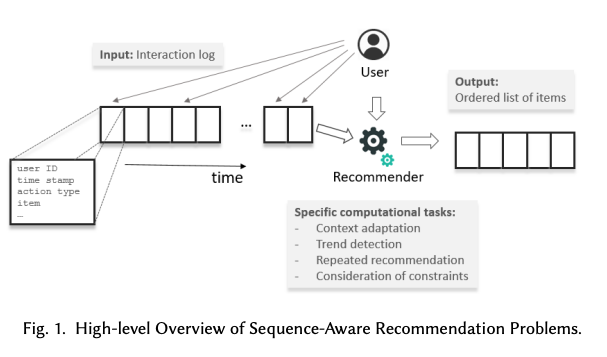

Source: https://arxiv.org/pdf/1802.08452.pdf


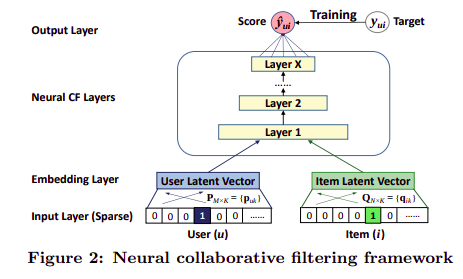

Source:https://www.hindawi.com/journals/complexity/2019/9476981/

### Outputs

The output of a sequence-aware recommender are ordered lists of emails. The ordering of the objects in the recommendation list is relevant.

## A Simplified Problem

We are going to simplify our problem by putting some contraints on our dataset and imposing assumptions. 

**Objective**: We want to predict the timing of a 3 part email series over the period of 7 days. 

We will call these email1, email2, and email3. These emails do not have to be sent in order. We assume that everyone receives email1 and that email1 is sent to everyone at a specific time. Email1 is our "time 0". We will measure time between emails in days. All emails must be sent. The most time you can wait to send any given email is 7 days. The emails can be sent on the same day.

We have no information about our users.

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow.keras as keras
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split
import random
import time

In [ ]:
rand = np.random.RandomState(1234)    

### Dataset

We are going to create a historical dataset that contains the binary action responses and timing of emails sent to each user in the past. Our dataset has 1000 customers. 

Note: email1 doesn't have a day because it is our time 0 email

Make some random data

https://stackabuse.com/generating-synthetic-data-with-numpy-and-scikit-learn/

#### Email2 Dataset

In [ ]:
customer_feature_1 = np.random.randint(0, 1, size = 1000, dtype = 'int')
customer_feature_2 = np.random.randint(0, 1, size = 1000, dtype = 'int')
email1_respsonse = np.random.randint(0, 1, size = 1000, dtype = 'int')
email2_timing = np.random.randint(0, 7, size = 1000, dtype = 'int')

x_email2 = pd.DataFrame(list(zip(customer_feature_1, customer_feature_2, email1_respsonse, email2_timing)),
                   columns = ['customer_feature_1', 'customer_feature_2', 'email1_response', 'email2_timing'])

x_email2.head()

In [ ]:
y_email2_response = np.random.randint(0, 1, size = 1000, dtype = 'int')

#### Email3 Dataset

In [ ]:
customer_feature_1 = np.random.randint(0, 1, size = 1000, dtype = 'int')
customer_feature_2 = np.random.randint(0, 1, size = 1000, dtype = 'int')
email1_respsonse = np.random.randint(0, 1, size = 1000, dtype = 'int')
email2_timing = y_email2_response
email2_response = y_email2_response

x_email3 = pd.DataFrame(list(zip(customer_feature_1, customer_feature_2, email1_respsonse, email2_timing, 
                                 email2_response)),
                   columns = ['customer_feature_1', 'customer_feature_2', 'email1_response'
                              , 'email2_timing', 'email2_response'])

x_email3.head()

In [6]:
y_email3_response = np.random.randint(0, 1, size = 1000, dtype = 'int')

## Modeling
Our model is dynamic in the sense that it updates every time receiving new data.

RNN models have long ‘memory’ across users’ preferences, they require large amounts of data (and especially dense data) before they can outperform simpler baselines. Self-attention mechanisms to sequential recommendation problems can move from sequential to temporal modeling. sequential recommenders discard timestamps and preserve only the order of items, that is, these methods (implictly) assume that all adjacent items in a sequence have the same time intervals.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x_email2, y_email2_response, test_size=0.33, random_state=42)

In [8]:
X_train.head()

,customer_feature_1,customer_feature_2,email1_response,email2_timing
703,0,0,0,3
311,0,0,0,5
722,0,0,0,4
629,0,0,0,1
0,0,0,0,0


In [9]:
inputs = keras.layers.Input((4, ))
x = keras.layers.Dense(10, activation='relu')(inputs)
x = keras.layers.Dense(10, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='ToyEmailModel')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X = X_train
y = y_train

# model.fit(x=X.values, 
#           y=y, 
#           batch_size=8,
#           epochs=200,
#           validation_split=0.15)

In [10]:
# model.evaluate(X_test, y_test, verbose=0)

## Online Modeling

### Progressive Validation

Compare the learning rates of two models over time

Source: https://static.googleusercontent.com/media/research.google.com/fr//pubs/archive/41159.pdf

In [11]:
X.head()

,customer_feature_1,customer_feature_2,email1_response,email2_timing
703,0,0,0,3
311,0,0,0,5
722,0,0,0,4
629,0,0,0,1
0,0,0,0,0


Our problem has a temporal aspect to it

In [12]:
def str_time_prop(start, end, format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formated in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, format))
    etime = time.mktime(time.strptime(end, format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%m/%d/%Y %I:%M %p', prop)

print()

In [13]:
X['date'] = X.apply(lambda x: random_date("1/1/2008 1:30 PM", "1/1/2009 4:50 AM", random.random()), axis=1)

<ipython-input-13-f1a44241cf86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['date'] = X.apply(lambda x: random_date("1/1/2008 1:30 PM", "1/1/2009 4:50 AM", random.random()), axis=1)


In [14]:
X.head()

,customer_feature_1,customer_feature_2,email1_response,email2_timing,date
703,0,0,0,3,03/06/2008 11:15 PM
311,0,0,0,5,07/07/2008 04:46 PM
722,0,0,0,4,09/28/2008 05:41 PM
629,0,0,0,1,03/21/2008 12:48 PM
0,0,0,0,0,08/07/2008 02:50 AM


In [15]:
X = X.sort_values(by='date')

Assume the Target Variable is a function

In [16]:
y = X.apply(lambda row: row.email2_timing - 
                        (row.email2_timing * 0.1), axis = 1)

In [17]:
X.head()

,customer_feature_1,customer_feature_2,email1_response,email2_timing,date
162,0,0,0,1,01/02/2008 07:06 AM
8,0,0,0,6,01/02/2008 07:41 PM
999,0,0,0,0,01/02/2008 08:28 AM
759,0,0,0,1,01/02/2008 10:33 PM
839,0,0,0,2,01/03/2008 10:55 PM


In [19]:
running_acc = 0
exp_acc = 0
scores = []
exp_scores = []
for i in range(0, len(X), 100):
    X_train = X.drop(['date'], axis=1)
    row = X[['customer_feature_1', 'customer_feature_2', 'email1_response', 'email2_timing']].iloc[i]
    # if fit hasn't been called yet, call it on the first batch
    if i == 0:
#         model.fit(x=X_train.values, 
#           y=y, 
#           batch_size=8,
#           epochs=200,
#           validation_split=0.15)
        continue
    else:
        xi = row
        date =  X[['date']].iloc[i]
        yi = y[i]
        # predict
        y_pred = model.predict(np.array([xi,]))[0]

        
        # Update the running accuracy
        acc = abs(y_pred - yi)
        running_acc += (acc - running_acc) / i

        # Update the exponential moving average
        exp_acc = .1 * acc + .9 * exp_acc

        # Store the metric at the current time
        if i >= 10:
            scores.append((date, running_acc))
            exp_scores.append((date, exp_acc))

        # Finally, make the model learn
        model.partial_fit(np.array([xi,]), [yi])

        if i == 38000:
            break

AttributeError: 'Functional' object has no attribute 'partial_fit'

### Binned Performance
binned performance to be defined as an average performance of the models available in bth bin between attaining instance data and receiving its true label

Source: https://link.springer.com/article/10.1007/s10618-019-00654-y

### Learning Distributions

Source: https://github.com/taboola/mdn-tensorflow-notebook-example/blob/master/mdn-tf2.ipynb

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input

In [ ]:
def f(x):
    return x**2-6*x+9

In [ ]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

In [ ]:

sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

In [ ]:

epochs = 500
batch_size = 50
learning_rate = 0.0003
model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse',optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()
print('Final cost: {0:.4f}'.format(history_cache.history['mse'][-1]))

In [ ]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

In [ ]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
InputLayer = Input(shape=(1,))
Layer_1 = Dense(12,activation="tanh")(InputLayer)
Layer_2 = Dense(12,activation="tanh")(Layer_1)
mu = Dense(1, activation="linear")(Layer_2)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([x_arr, y_arr], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
mu_pred, sigma_pred = model.predict(list((x_test,x_test))) # the model expects a list of arrays as it has 2 inputs
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

# Rec. Systems Part 3:

- Refinforcement (cold start problem)
- Injecting randomness (exploration)
- Rules to limit too similar or too popular of recommendations (remove bias)
    -> consumers are unlikely to action on two messages sent in close succession
- Waht is the scale at which we are exploring?
- Multi-target (implicit feedback)

- Scale item ratings by user value (i.e. are some attriubtes of actions more "valueable" to the customer or to mutual?)
    -> Composite reward function
    -> heirchtical multitarget recommender system

- How does a neural network recommender system explore?

#### Recency
For example, someone’s tastes collected yesterday are better indications of that person’s taste compared to his tastes collected the previous year

#### Delayed Labeling
how frequently to get new predictions for an instance of interest awaiting its true label. a new prediction for will be made every new instance until a set amount of true labels arrive. The periods of waiting for the labels can be decomposed into subperiods to analyse the changes in the performance measures before the labels arrive.

Sources: 
* https://link.springer.com/article/10.1007/s10618-019-00654-y
* https://maxhalford.github.io/blog/online-learning-evaluation/#cross-validation

#### Hyperparameter Selection
![Screen%20Shot%202021-02-08%20at%2010.48.27%20AM.png](attachment:Screen%20Shot%202021-02-08%20at%2010.48.27%20AM.png)

Source: https://static.googleusercontent.com/media/research.google.com/fr//pubs/archive/41159.pdf

Assumptions?
- consumers are unlikely to action on two messages sent in close succession
- Would we be okay with sending all of the emails on one day?
- We can also probably assume we don't want to years to send the second email